In [1]:
# create the configuration of the low-fidelity model
import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import pearsonr
from mfbml.methods.mf_dnn_bnn import MFDNNBNN
from mfbml.methods.bnn import BNNWrapper
from mfbml.methods.sequential_mf_bnn import SequentialMFBNN
from mfbml.problems.illutrative_problems import Forrester1b
from mfbml.metrics.accuracy_metrics import (
    mean_log_likelihood_value,
    normalized_mae,
    normalized_rmse,
)
from mfbml.methods.mf_rbf_gpr import MFRBFGPR

# fix the random seed for reproducibility
np.random.seed(1)
torch.manual_seed(1)

In [2]:
# define function
func = Forrester1b(noise_std=0.1)
num_dim = 1

# generate samples (21 HF samples, 201 LF samples)
lf_samples = torch.linspace(-1, 2, 201).reshape(-1, 1)
hf_samples = torch.linspace(0, 1, 7).reshape(-1, 1)


# generate responses
lf_responses = func.lf(lf_samples)
hf_responses = func.hf(hf_samples)

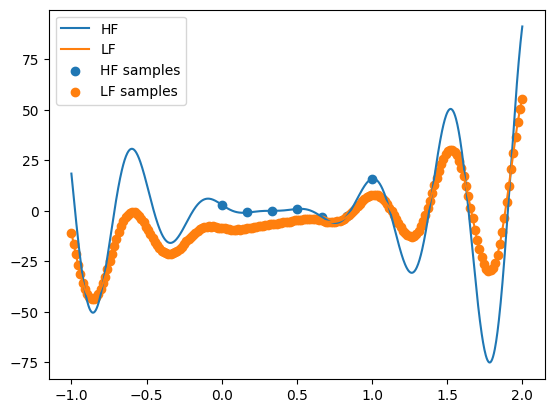

In [3]:
# generate the test points
test_samples = torch.linspace(-1, 2, 1001).reshape(-1, 1)
# noiseless responses
test_hf_responses_noiseless = func.hf(test_samples, noise_hf=0.0)
test_lf_responses_noiseless = func.lf(test_samples, noise_lf=0.0)

# noise responses
test_hf_responses = func.hf(test_samples)
test_lf_responses = func.lf(test_samples)

# plot the function
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot test noisy responses
# ax.scatter(test_samples, test_hf_responses, label="HF noise responses")
# ax.scatter(test_samples, test_lf_responses, label="LF noise responses")
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [5]:
# train a mf-rbf-gpr model first
# to have a gpr model for this problem
samples_gpr = [hf_samples.numpy(), lf_samples.numpy()]
responses_gpr = [hf_responses.numpy(), lf_responses.numpy()]

# create the MFRBFGPR object
mfrbfgpr = MFRBFGPR(
    design_space=np.array([[0, 1]]), noise_prior=0.1, optimizer_restart=20
)
# train the model
mfrbfgpr.train(
    samples=samples_gpr,
    responses=responses_gpr,
)

# get prediciton for the MFRBFGPR object
y_mfrbfgpr, total_unc_mfrbfgpr = mfrbfgpr.predict(
    X=test_samples.numpy(), return_std=True
)

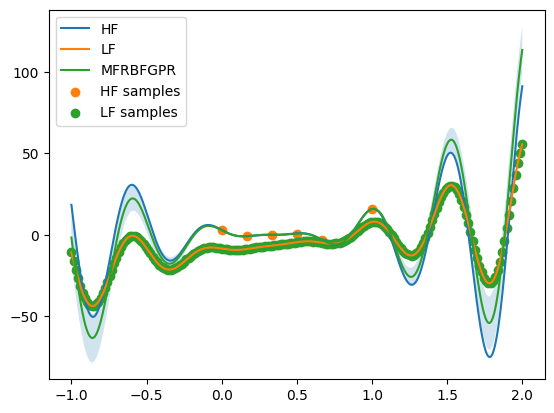

In [6]:
# plot the prediction
fig, ax = plt.subplots()
ax.plot(test_samples, test_hf_responses_noiseless, label="HF")
ax.plot(test_samples, test_lf_responses_noiseless, label="LF")
# plot the prediction
ax.plot(test_samples, y_mfrbfgpr, label="MFRBFGPR")
# plot the uncertainty
ax.fill_between(
    test_samples.flatten(),
    (y_mfrbfgpr - 1.96 * total_unc_mfrbfgpr).flatten(),
    (y_mfrbfgpr + 1.96 * total_unc_mfrbfgpr).flatten(),
    alpha=0.2,
)
# plot the samples
ax.scatter(hf_samples, hf_responses, label="HF samples")
ax.scatter(lf_samples, lf_responses, label="LF samples")
plt.legend()
plt.show()

In [7]:
# the learned beta
print(mfrbfgpr.beta.T)

[[2.1781443  1.92581119]]


## Configurations for DNN and BNNs


In [8]:
# create the configuration of the low-fidelity model
lf_configure = {
    "in_features": 1,
    "hidden_features": [20, 20],
    "out_features": 1,
    "activation": "Tanh",
    "optimizer": "Adam",
    "lr": 0.001,
    "weight_decay": 0.0001,
    "loss": "mse",
}
# create the configuration of the high-fidelity model
hf_parallel_configure = {
    "in_features": 1,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}
#
hf_sequential_configure = {
    "in_features": 2,
    "hidden_features": [50, 50],
    "out_features": 1,
    "activation": "Tanh",
    "lr": 0.01,
    "sigma": 0.1,
}

# training configure
samples = {"lf": lf_samples, "hf": hf_samples}

responses = {"lf": lf_responses, "hf": hf_responses}

# lf train config
lf_train_config = {
    "batch_size": None,
    "num_epochs": 10000,
    "print_iter": 1000,
    "data_split": True,
}
hf_train_config = {
    "num_epochs": 10000,
    "sample_freq": 50,
    "print_info": True,
    "burn_in_epochs": 100,
}

# training of sequential MF-DNN-BNN model


In [9]:
# sequential mf-bnn
sequential_bnn = SequentialMFBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_sequential_configure,
)
# train the model
sequential_bnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  1000 train loss:  0.6363628506660461 test loss:  0.49635589122772217
epoch:  2000 train loss:  0.30847105383872986 test loss:  0.33861276507377625
epoch:  3000 train loss:  0.045573361217975616 test loss:  0.061531584709882736
epoch:  4000 train loss:  0.006766187958419323 test loss:  0.0070181372575461864
epoch:  5000 train loss:  0.003821632359176874 test loss:  0.00412945169955492
epoch:  6000 train loss:  0.0029050339944660664 test loss:  0.003199075348675251
epoch:  7000 train loss:  0.001734836958348751 test loss:  0.0017480668611824512
epoch:  8000 train loss:  0.00081135134678334 test loss:  0.0007453067228198051
epoch:  9000 train loss:  0.00030183824128471315 test loss:  0.00025341418222524226
epoch:  10000 train loss:  0.00033797917421907187 test loss:  0.0002704117796383798
epoch:     0/10000
nll_loss: 12117.277, prior_loss: 2548.864, total: 14666.141
noise: 0.015


/home/yaga/Documents/mfbml/src/mfbml/methods/bnn.py:170: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  V.mul_(alpha).addcmul_(1 - alpha, d_p, d_p)


epoch:   100/10000
nll_loss: 300.447, prior_loss: 2588.466, total: 2888.913
noise: 0.015
epoch:   200/10000
nll_loss: 127.429, prior_loss: 2622.100, total: 2749.529
noise: 0.015
epoch:   300/10000
nll_loss: 126.549, prior_loss: 2661.536, total: 2788.086
noise: 0.015
epoch:   400/10000
nll_loss: 557.185, prior_loss: 2713.443, total: 3270.629
noise: 0.015
epoch:   500/10000
nll_loss: 12.564, prior_loss: 2776.884, total: 2789.447
noise: 0.015
epoch:   600/10000
nll_loss: 57.685, prior_loss: 2823.791, total: 2881.476
noise: 0.015
epoch:   700/10000
nll_loss: 583.653, prior_loss: 2908.664, total: 3492.317
noise: 0.015
epoch:   800/10000
nll_loss: 38.459, prior_loss: 2985.549, total: 3024.008
noise: 0.015
epoch:   900/10000
nll_loss: 32.809, prior_loss: 3023.338, total: 3056.147
noise: 0.015
epoch:  1000/10000
nll_loss: 14.740, prior_loss: 3079.855, total: 3094.595
noise: 0.015
epoch:  1100/10000
nll_loss: 307.886, prior_loss: 3166.136, total: 3474.022
noise: 0.015
epoch:  1200/10000
nll_los

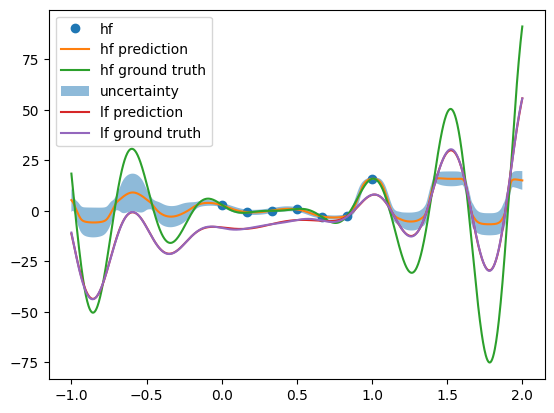

In [10]:
# visualize the posterior of sequential mf-bnn
(
    sequential_bnn_y,
    sequential_bnn_epistemic,
    sequential_bnn_total_unc,
    sequential_bnn_aleatoric,
) = sequential_bnn.predict(x=test_samples)
# get lf predictions
sequential_bnn_lf_y = sequential_bnn.predict_lf(x=test_samples)
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), sequential_bnn_y, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
ax.plot(test_samples.numpy(), sequential_bnn_lf_y.detach(), label="lf prediction")
ax.plot(
    test_samples.numpy(),
    test_lf_responses_noiseless.numpy(),
    label="lf ground truth",
)
ax.legend()
plt.show()

In [11]:
# create the MFDNNBNN object
mfdnnbnn = MFDNNBNN(
    design_space=torch.Tensor([[0, 1]]),
    lf_configure=lf_configure,
    hf_configure=hf_parallel_configure,
    beta_optimize=False,
    beta_bounds=[-5, 5],
    discrepancy_normalization="hf",
)
# define beta
mfdnnbnn.beta = np.array([mfrbfgpr.beta[0, 0], mfrbfgpr.beta[1, 0]])
mfdnnbnn.train(
    samples=samples,
    responses=responses,
    lf_train_config=lf_train_config,
    hf_train_config=hf_train_config,
)

epoch:  1000 train loss:  0.5626689791679382 test loss:  0.4535421133041382
epoch:  2000 train loss:  0.49387168884277344 test loss:  0.4514455199241638
epoch:  3000 train loss:  0.004919745959341526 test loss:  0.0051588211208581924
epoch:  4000 train loss:  0.002218087902292609 test loss:  0.002280232962220907
epoch:  5000 train loss:  0.0015991867985576391 test loss:  0.0017036114586517215
epoch:  6000 train loss:  0.0007268983172252774 test loss:  0.0006665563560090959
epoch:  7000 train loss:  0.00038381648482754827 test loss:  0.0003057053836528212
epoch:  8000 train loss:  0.0003382749273441732 test loss:  0.00029333122074604034
epoch:  9000 train loss:  0.000313015712890774 test loss:  0.00028545476379804313
epoch:  10000 train loss:  0.00030234080622904 test loss:  0.0002829890581779182
optimized beta: [2.1781443  1.92581119]
epoch:     0/10000
nll_loss: 18399.246, prior_loss: 2508.311, total: 20907.557
noise: 0.015
epoch:   100/10000
nll_loss: 41.985, prior_loss: 2545.039, to

In [ ]:
# predict the MFDNNBNN object
(
    y_proposed,
    epistemic_proposed,
    total_unc_proposed,
    aleatoric_proposed,
) = mfdnnbnn.predict(x=test_samples)
# lf prediction
lf_y_proposed = mfdnnbnn.predict_lf(test_samples)

In [ ]:
# plot
fig, ax = plt.subplots()
ax.plot(hf_samples, hf_responses, "o", label="hf")
ax.plot(test_samples.numpy(), y_proposed, label="hf prediction")
ax.plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    label="hf ground truth",
)
ax.fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * epistemic_proposed).reshape(-1),
    (y_proposed + 2 * epistemic_proposed).reshape(-1),
    alpha=0.5,
    label="uncertainty",
)
# plot lf samples
ax.scatter(lf_samples, lf_responses, label="LF samples")
ax.plot(test_samples.numpy(), lf_y_proposed.detach().numpy(),
        label="LF prediction")
ax.legend()
plt.show()

In [ ]:
# plot two figures together
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
# plot sequential mf-bnn
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_y,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[1].plot(
    hf_samples, hf_responses, "kx", linewidth=2, markersize=10, label="HF samples"
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (sequential_bnn_y - 2 * sequential_bnn_total_unc).reshape(-1),
    (sequential_bnn_y + 2 * sequential_bnn_total_unc).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
ax[1].plot(
    test_samples.numpy(),
    sequential_bnn_lf_y.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
# ax[1].legend()
ax[1].set_title("Concatenate MF-BNN", fontsize=16)
ax[1].set_xlim([0, 2])
ax[1].set_ylim([-100, 100])
# plot MFRBFGPR
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)

ax[0].plot(
    hf_samples,
    hf_responses,
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr
    - mfrbfgpr.beta[1, 0] * mfrbfgpr.lf_model.predict(test_samples.numpy())
    - mfrbfgpr.beta[0, 0],
    linewidth=2,
    color="#AA4499",
    label=r"$f^d(x)$",
)
# ax[0].legend()
ax[0].set_title("MF-KRR-GPR", fontsize=16)
ax[0].set_xlim([0, 2])
ax[0].set_ylim([-100, 100])
# plot MFDNNBNN
ax[2].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#33BBEE",
    linewidth=2,
    label="HF truth",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#CC3311",
    linewidth=2,
    label="HF prediction",
)
ax[2].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[2].plot(
    hf_samples,
    hf_responses,
    "kx",
    linewidth=2,
    markersize=10,
    label="HF samples",
)
# plot lf samples
ax[2].plot(
    test_samples.numpy(),
    lf_y_proposed.detach().numpy(),
    "-",
    color="#0077BB",
    linewidth=2,
    label="LF prediction",
)
ax[2].plot(
    test_samples.numpy(),
    y_proposed
    - mfrbfgpr.beta[1, 0] * lf_y_proposed.detach().numpy()
    - mfrbfgpr.beta[0, 0],
    linewidth=2,
    color="#AA4499",
    label=r"$f^d(x)$",
)
ax[2].set_title("MF-DNN-BNN", fontsize=16)
ax[2].set_xlim([0, 2])
ax[2].set_ylim([-100, 100])


plt.legend(loc="upper center", bbox_to_anchor=(-0.7, 1.30), ncol=6, fontsize=14)
# set the font size of axis
for i in range(3):
    ax[i].tick_params(axis="both", which="major", labelsize=16)
    # set the line width of the axis
    for axis in ["top", "bottom", "left", "right"]:
        ax[i].spines[axis].set_linewidth(1.5)


plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()

In [ ]:
# plot comparison betw
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[0].fill_between(
    test_samples.flatten().numpy(),
    (y_mfrbfgpr - 2 * total_unc_mfrbfgpr).reshape(-1),
    (y_mfrbfgpr + 2 * total_unc_mfrbfgpr).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
ax[0].plot(
    test_samples.numpy(),
    mfrbfgpr.lf_model.predict(test_samples.numpy()),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[0].plot(
    test_samples.numpy(),
    y_mfrbfgpr - 1.9144 * mfrbfgpr.lf_model.predict(test_samples.numpy()),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[0].legend()
ax[0].set_title("MF-RBF-GPR")
ax[0].set_xlabel("x", fontsize=12)
ax[0].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[0].tick_params(axis="both", which="major", labelsize=12)
# ax[1].set_xlim([0, 1.5])

# plot MFDNNBNN
ax[1].plot(
    hf_samples,
    hf_responses,
    "x",
    color="#EE3377",
    linewidth=2,
    markersize=8,
    label="HF samples",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed,
    "-",
    color="#0077BB",
    linewidth=2,
    label="HF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    test_hf_responses_noiseless.numpy(),
    "--",
    color="#EE7733",
    linewidth=2,
    label="HF noiseless truth",
)
ax[1].fill_between(
    test_samples.flatten().numpy(),
    (y_proposed - 2 * total_unc_proposed).reshape(-1),
    (y_proposed + 2 * total_unc_proposed).reshape(-1),
    alpha=0.5,
    color="#BBBBBB",
    label="CI interval",
)
# plot lf samples
# ax[1].scatter(lf_samples, lf_responses, label="LF samples")
# ax[1].plot(test_samples.numpy(), lf_y_proposed.detach().numpy(), label="LF prediction")
ax[1].plot(
    test_samples.numpy(),
    lf_y_proposed.detach().numpy(),
    "-",
    color="#CC3311",
    linewidth=2,
    label="LF prediction",
)
ax[1].plot(
    test_samples.numpy(),
    y_proposed - 1.9144 * lf_y_proposed.detach().numpy(),
    label=r"$f^d(x)$",
    color="#009988",
    linewidth=2,
)

ax[1].legend()
ax[1].set_title("MF-DNN-BNN")
ax[1].set_xlabel("x", fontsize=12)
ax[1].set_ylabel("y", fontsize=12)
# set the font size of axis
ax[1].tick_params(axis="both", which="major", labelsize=12)
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.png", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.pdf", dpi=300, bbox_inches="tight")
plt.savefig("mf_dnn_bnn_vs_mf_rbf_gpr.svg", dpi=300, bbox_inches="tight")
plt.show()